# Linear Regression with Temperature and Reported Crime Counts

**Author:** Travis Hathaway

### Summary
This Jupyter Notebook collects data from NOAA and stores it in our Postgres database. We then use this data to create a linear regression with reported crime temperature as our dependent (y axis) variable and report counts as our independent varaible (x axis).  Our current database only has reported crime from 2004 to 2014

### Data Sources
- **Crime Reports Data:** ftp://ftp02.portlandoregon.gov/CivicApps/
- **NOAA Temperature Data:** http://www.wrh.noaa.gov/pqr/climate/PDXtemp.txt

### Requirements
- Running instance of Postgres with the Portland Reported Crimes database **[Download PostgreSQL dump here](https://drive.google.com/file/d/0B_NwBaDdu_zrNVVWc0VGWE9mdjg/view?usp=sharing)**
- The following Python dependencies:
    - pyscopg2
    - requests
    - numpy
    - pandas
    - matplotlib
    - statsmodels

In [12]:
import psycopg2
import requests
from calendar import monthrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde

%matplotlib inline  

def get_conn():
    """
    When running this notebook locally, fill in the following values to
    match your environment
    """
    conn_data = {
        'database': 'crimestats2',
        'user': 'travishathaway',
        'host': 'localhost',
        'password': ''
    }

    return psycopg2.connect(**conn_data)

### Constaints and Utility Functions
Changes these to match your local running instance or disired data sources

In [2]:
POSTGRES_CONN_DATA = {
    'database': 'crimestats2',
    'user': 'travishathaway',
    'host': 'localhost',
    'password': ''
}

TEMPERATURE_DATA_URL = 'http://www.wrh.noaa.gov/pqr/climate/PDXtemp.txt'
NEW_LINE_CHAR = '\r\n'
LOCATION = 'PDX'

def get_conn(conn_data=POSTGRES_CONN_DATA):
    return psycopg2.connect(**conn_data)

### Step 1: Create the table we will use to store our tempature data

In [3]:
conn = get_conn()
cur = conn.cursor()

In [4]:
temp_table_ddl = """
    CREATE TABLE IF NOT EXISTS historical_temps (
        record_date date not null,
        low_temp FLOAT,
        high_temp FLOAT,
        location varchar(100) not null,
        CONSTRAINT pk_historical_temps UNIQUE(record_date, location)
    )
"""

In [5]:
cur.execute(temp_table_ddl)
conn.commit()
conn.close()

### Step 2: Retrieve the data from NOAA

In [6]:
resp = requests.get(TEMPERATURE_DATA_URL)

if resp.status_code == 200 and resp.text:
    raw_data = resp.text
else:
    raw_data = ''
    raise Exception('No data found for given URL')

# The first seven lines of this file are not important
raw_data = raw_data.split(NEW_LINE_CHAR)[7:]

# The next row contains the header information for subsequent rows
headers = raw_data.pop(0).split()

### Step 3: Parse it to a friendlier format
This is how we want our temperature data to look after we have parsed it.

```python
temperature_data = [
    ('low', '1941-12-01', 30, 'PDX'),
    ('high', '1941-12-01', 50, 'PDX'),
]
```

In [7]:
temperature_data = []
temp_type_map = {
    'TN': 'low',
    'TX': 'high'
}

for row in raw_data:
    row_data = row.split()
    try:
        cur_year = row_data[0]
        cur_month = row_data[1].replace('TX', '').replace('TN', '')
        temp_type = row_data[1][-2:]
    except IndexError:
        break

    month_high = monthrange(int(cur_year), int(cur_month))[1]

    for idx, temp in enumerate(row_data[2:], 1):
        if idx > month_high:
            continue
        if temp == 'M':
            temp = None
            
            
        temperature_data.append({
            'temp_type': temp_type_map[temp_type],
            'record_date': '{}-{}-{}'.format(
                cur_year, cur_month.zfill(2), str(idx).zfill(2)
            ),
            '{}_temp'.format(temp_type_map[temp_type]): temp,
            'location': LOCATION
        })

### Step 4 : Load this data to postgres

In [8]:
conn = get_conn()
cur = conn.cursor()

for row in temperature_data:
    query = """
        INSERT INTO 
            historical_temps (record_date, {temp_type}_temp, location)
        VALUES
            (%(record_date)s, %({temp_type}_temp)s, %(location)s)
        ON CONFLICT
            (record_date, location)
        DO UPDATE SET 
            {temp_type}_temp = %({temp_type}_temp)s
    """.format(temp_type=row['temp_type'])
    
    cur.execute(query, row)
    
conn.commit()
conn.close()

### Step 5: Create a linear regression

Now, we are ready to create our linear regression using temperature and crime report data.

The first step is running a query that will return the following from our database:
- Average Temperature
- Report Count

In [9]:
conn = get_conn()

In [10]:
temp_report_query = """
    select 
        (t.high_temp + t.low_temp)/ 2 as temp, count(*) as count
    from 
        portland_crime_stats r 
    left join 
        historical_temps t on r.report_date = t.record_date
    group by 
        r.report_date, (t.high_temp + t.low_temp)/ 2
"""

df1 = pd.read_sql(temp_report_query, conn)

Let's go ahead and take a peak at this dataset.

In [11]:
df1.head()

,temp,count
0,34.5,149
1,38.0,176
2,38.5,192
3,30.5,158
4,22.0,176


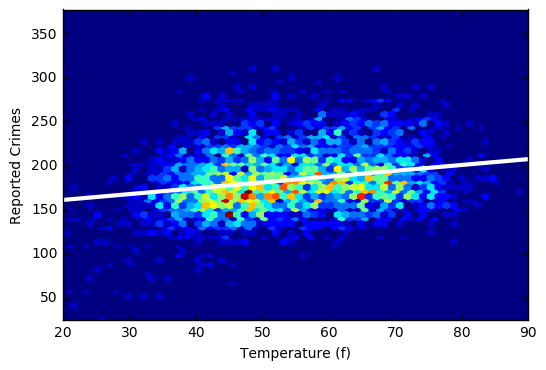

In [8]:
y = df1['count']
x = df1['temp']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=75, edgecolor='')
ax.hexbin(x, y, gridsize=60)
ax.set_xlabel('Temperature (f)')
ax.set_ylabel('Reported Crimes')

fit = np.polyfit(x, y , 1)
fit_fn = np.poly1d(fit)

x_lin = np.linspace(min(x), max(x), 100)
y_lin = fit_fn(x_lin)

plt.plot(x_lin, y_lin, linewidth='3', color='white')
plt.show()
# formula = 'count ~ temp'
# model = smf.ols(formula, data=df1)
# results = model.fit()

#plt.xlim(0, 5)
#plt.ylim(0, 12)
#df.plot(kind='scatter', x='count', y='avg_temp')

In [5]:
temp_report_query = """
SELECT 
    temp, avg(count) as avg_count, stddev(count) as stddev
FROM
    ( 
        SELECT
            (t.high_temp + t.low_temp)/ 2 as temp, 
            count(*) as count
        FROM
            portland_crime_stats r
        LEFT JOIN
            historical_temps t 
        ON 
            r.report_date = t.record_date
        WHERE 
            major_offense_type = 'Liquor Laws'
        GROUP BY
            r.report_date, (t.high_temp + t.low_temp)/ 2
    )
AS t
GROUP BY temp
"""

df = pd.read_sql(temp_report_query, conn)

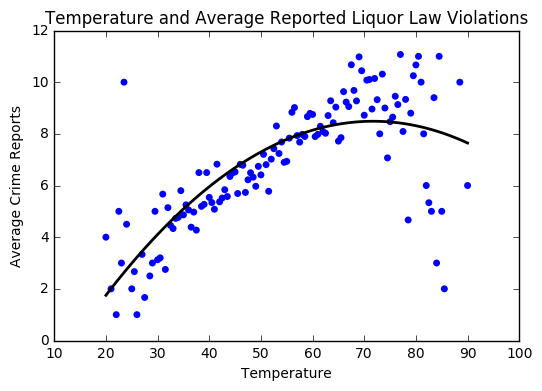

In [29]:
y = df['avg_count']
x = df['temp']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, s=25, edgecolor='')
ax.set_xlabel('Temperature')
ax.set_ylabel('Average Crime Reports')
ax.set_title('Temperature and Average Reported Liquor Law Violations')

fit = np.polyfit(x, y , 2)
fit_fn = np.poly1d(fit)

x_lin = np.linspace(min(x), max(x), 100)
y_lin = fit_fn(x_lin)

plt.plot(x_lin, y_lin, linewidth='2', color='black')
plt.show()
formula = 'avg_count ~ temp'
model = smf.ols(formula, data=df)
results = model.fit()

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_count   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     113.2
Date:                Mon, 06 Mar 2017   Prob (F-statistic):           2.72e-19
Time:                        18:10:16   Log-Likelihood:                -256.01
No. Observations:                 129   AIC:                             516.0
Df Residuals:                     127   BIC:                             521.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0485      0.476      4.303      0.000       1.106       2.991
temp           0.0879      0.008     10.639      0.000       0.072       0.104
==============================================================================
Omnibus:                       42.787   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.145
Skew:                          -1.256   Prob(JB):                     2.21e-26
Kurtosis:                       6.958   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""